# PayTM WebBlogs Challenge

Necessary imports

In [111]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import (DateType, StringType, StructField, StructType, TimestampType, ArrayType,
                               FloatType, IntegerType, LongType)
import pyspark.sql.functions as F
from pyspark.sql import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator, Normalizer

from operator import add
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta  

%matplotlib inline

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

Create the schema for reading the data from the given file.

**NOTE**: I am reading the timestamp as *StringType* rather than *TimestampType* since I noticed with *TimestampType*, there is some loss of precision down the road.

In [5]:
schema = StructType([
    StructField("timestamp", StringType()),
    StructField("elb", StringType()),
    StructField("client_port", StringType()),
    StructField("backend_port", StringType()),
    StructField("request_processing_time", FloatType()),
    StructField("backend_processing_time", FloatType()),
    StructField("response_processing_time", FloatType()),
    StructField("elb_status_code", IntegerType()),
    StructField("backend_status_code", IntegerType()),
    StructField("received_bytes", LongType()),
    StructField("sent_bytes", LongType()),
    StructField("request", StringType()),
    StructField("user_agent", StringType()),
    StructField("ssl_cipher", StringType()),
    StructField("ssl_protocol", StringType())
])

Now read in the file and view the schema

In [6]:
df = spark.read.csv('2015_07_22_mktplace_shop_web_log_sample.log', sep=' ', schema=schema)
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- elb: string (nullable = true)
 |-- client_port: string (nullable = true)
 |-- backend_port: string (nullable = true)
 |-- request_processing_time: float (nullable = true)
 |-- backend_processing_time: float (nullable = true)
 |-- response_processing_time: float (nullable = true)
 |-- elb_status_code: integer (nullable = true)
 |-- backend_status_code: integer (nullable = true)
 |-- received_bytes: long (nullable = true)
 |-- sent_bytes: long (nullable = true)
 |-- request: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- ssl_cipher: string (nullable = true)
 |-- ssl_protocol: string (nullable = true)



Have a look at some sample data

In [7]:
df.show(5, False)

+---------------------------+----------------+---------------------+-------------+-----------------------+-----------------------+------------------------+---------------+-------------------+--------------+----------+----------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+---------------------------+------------+
|timestamp                  |elb             |client_port          |backend_port |request_processing_time|backend_processing_time|response_processing_time|elb_status_code|backend_status_code|received_bytes|sent_bytes|request                                                                                                         |user_agent                                                                                                   |ssl_cipher                 |ssl_protocol|
+---------------------------+-------

## Question 1: Sessionize the data by IP

For this, I mostly followed the sessionizing scheme described [here](https://mode.com/blog/finding-user-sessions-sql), with a slight modification. I will describe the scheme in short here:

1. Consider the idle time limit (session timeout) to be say x minutes.
2. Now if we find more than x minutes of time interval between the response time of a request and the request time of the subsequent request, that's most probably an indication of the start of a new session. **NOTE** that I am not considering the *idle time* as part of the session,. In other words, the effective end of the session would be the last response he got before the start of another session.
3. Now I did some experimentation on how to determine the best value for x.
  For this, I followed a simple heuristic that I made up. The way it works is as follows:
  - Have a list of possible candidates for x. In my case I took [15, 30, 35, 45, 60], meaning 15 minutes, 30 minutes,     35 minutes, 45 minutes and 60 minutes. Also have a buffer time of y minutes. In my case, I took y = 10.
  - For each value in this list, follow the sessionizing scheme of bullet point 2 above. 
  - Once sessionized, for each IP, after a session ends, measure how many sessions do not restart within y        minutes after the session timeout (x) is reached. Let's say our candidate x value is 30 minutes, and y value is 10 minutes. So in this case, first calculate how many sessions have more than 30 minutes of idle time after they are finished. Let's say this number is m. Now measure, how many sessions have more than (30 + 10) = 40 minutes of idle time after they are finished. Let's say this number is n. The closer n is to m, the higher the number of sessions are that did not restart within 10 minutes after the 30 minutes idle time. So basically we have to measure the n/m ratio. The higher this ratio is, the better the x value will be a candiadte for the session idle time. 
  
  In my case, I found that the 35 minutes idle time gave me the highest ratio of 1, so decided to go with 35 minutes.

Now define a few utility functions that will be useful. I have converted the timestamp into double values (epoch up to nanosecond precision) so that later on subtraction operations can be done elegantly.

In [8]:
timestamp_format = "yyyy-MM-dd'T'HH:mm:ss"

def request_timestamp(time_col):
    return (F.to_timestamp(time_col, format=timestamp_format).cast('double') + \
            F.substring(time_col, -8, 7).cast('double'))

def return_timestamp(time_col):
    return request_timestamp(time_col) + \
            F.when(F.col('request_processing_time') == -1, 0.0).otherwise(F.col('request_processing_time')) + \
            F.when(F.col('backend_processing_time') == -1, 0.0).otherwise(F.col('backend_processing_time')) + \
            F.when(F.col('response_processing_time') == -1, 0.0).otherwise(F.col('response_processing_time'))

In [9]:
df_with_time_and_ip = df.select('timestamp',
                    request_timestamp('timestamp').alias('request_timestamp'),
                    return_timestamp('timestamp').alias('return_timestamp'),
                    F.substring_index('client_port', ':', 1).alias('client_ip'),
                    F.regexp_extract('request', r'https{0,1}:[^\s]+', 0).alias('url'))

In [10]:
df_with_time_and_ip.show(5, False)

+---------------------------+-------------------+--------------------+---------------+---------------------------------------------------------------------------------------------------+
|timestamp                  |request_timestamp  |return_timestamp    |client_ip      |url                                                                                                |
+---------------------------+-------------------+--------------------+---------------+---------------------------------------------------------------------------------------------------+
|2015-07-22T09:00:28.019143Z|1.437570028019143E9|1.437570028045294E9 |123.242.248.130|https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null       |
|2015-07-22T09:00:27.894580Z|1.43757002789458E9 |1.43757002804797E9  |203.91.211.44  |https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2      |
|2015-07-22T09:00:27.885745Z|1.437570027885745E9|1.43757002805074

In [11]:
df_with_time_and_ip.createOrReplaceTempView('df_with_time_and_ip')

Now here is the function that has all the sessionization logic (discussed above) embedded.

In [17]:
def get_sessioned_data(idle_time=1800, buffer=600):
    idle_time_plus_buffer = idle_time + buffer
    
    # query for detrmining potential session
    df_sessionized = spark.sql("""
        with last_return_timestamp_info as (
            select *,
            LAG(return_timestamp, 1) OVER
            (PARTITION BY client_ip ORDER BY request_timestamp) AS last_return_timestamp 
            from df_with_time_and_ip
        ),
        request_time_diff as 
        (
            select *, request_timestamp - last_return_timestamp as diff_with_previous_request 
            from last_return_timestamp_info
        ),
        session_start_info as 
        (
            select *,
                case when diff_with_previous_request > {idle_time} or last_return_timestamp is null then 1 
                     else 0 end as session_start
            from request_time_diff
        )
        select timestamp, 
            request_timestamp, 
            return_timestamp, 
            client_ip, 
            url,
            last_return_timestamp,
            diff_with_previous_request,
            SUM(session_start) OVER (PARTITION BY client_ip order by request_timestamp) as user_session_id,
            SUM(session_start) OVER (ORDER BY client_ip, request_timestamp) AS global_session_id
        from session_start_info
        """.format(idle_time=idle_time))
    df_sessionized.createOrReplaceTempView('df_sessionized')
    
    # once sessions are found, get the start and end times and session lengths
    df_session_with_length = spark.sql("""
        select client_ip, 
                user_session_id, 
                min(request_timestamp) as session_start_time,
                max(return_timestamp) as session_end_time,
                max(return_timestamp) - min(request_timestamp) as session_length
        from df_sessionized
        group by client_ip, user_session_id
        """)
    df_session_with_length.createOrReplaceTempView('df_session_with_length')
    
    
    # the logic below is basically for finding the non-returning session ratio discussed above
    # this ratio is used for finding the ideal idle time
    df_sessions_with_idle_time = spark.sql("""
        with last_sessions as (
            select client_ip, session_start_time, session_end_time,
            LAG(session_end_time, 1) OVER (partition by client_ip order by session_start_time) as last_session_end_time
            from df_session_with_length
        )
        select client_ip, (session_start_time - last_session_end_time) as idle_time
        from last_sessions
    """)
    
    df_sessions_with_idle_time.createOrReplaceTempView('df_sessions_with_idle_time')
    
    session_count = spark.sql("""
        select * from df_sessions_with_idle_time where idle_time > {idle_buffer}
    """.format(idle_buffer=idle_time)).count()
    
    non_returning_session_count = spark.sql("""
        select * from df_sessions_with_idle_time where idle_time > {idle_buffer}
    """.format(idle_buffer=idle_time_plus_buffer)).count()
    
    non_returning_session_ratio = non_returning_session_count * 1.0 / session_count
    
    return df_sessionized, df_session_with_length, non_returning_session_ratio

In [16]:
for idle_time in [15 * 60, 30 * 60, 35 * 60, 45 * 60, 60 * 60]:
    df_sessionized, df_session_with_length, non_returning_session_ratio = get_sessioned_data(idle_time)
    print('Idle Time: {} minutes, non-returning user ratio {}'.format(idle_time / 60, non_returning_session_ratio))

Idle Time: 15.0 minutes, non-returning user ratio 0.7961959199763476
Idle Time: 30.0 minutes, non-returning user ratio 0.9813243900835141
Idle Time: 35.0 minutes, non-returning user ratio 1.0
Idle Time: 45.0 minutes, non-returning user ratio 0.9998659786906118
Idle Time: 60.0 minutes, non-returning user ratio 0.983604260089686


Since from the above experimentation, we see that arond the 35 minute mark, we have a non-returning user ratio of 1,
we choose 35 minutes as our idle time.

In [18]:
df_sessionized, df_session_with_length, non_returning_session_ratio = get_sessioned_data(35 * 60)

Although not required for the analysis, I am just visualizing the distribution of the session lengths. Looks like most sessions are of lengths 1 - 4 minutes 

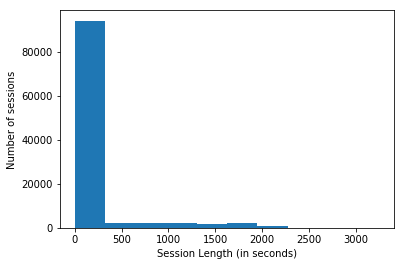

In [20]:
df_session_length_pd = df_session_with_length.select('session_length').toPandas()
plt.hist(df_session_length_pd['session_length'])
plt.xlabel('Session Length (in seconds)')
plt.ylabel('Number of sessions')
plt.show()

Let's have a look at the sessionized data.

In [26]:
df_sessionized.show(5, False)

+---------------------------+-------------------+--------------------+------------+---------------------------------------------------------------------------------------------+---------------------+--------------------------+---------------+-----------------+
|timestamp                  |request_timestamp  |return_timestamp    |client_ip   |url                                                                                          |last_return_timestamp|diff_with_previous_request|user_session_id|global_session_id|
+---------------------------+-------------------+--------------------+------------+---------------------------------------------------------------------------------------------+---------------------+--------------------------+---------------+-----------------+
|2015-07-22T10:45:55.881199Z|1.437576355881199E9|1.43757635595924E9  |1.186.101.79|https://paytm.com:443/shop/wallet/balance?channel=web&version=2                              |null                 |null              

In [22]:
df_session_with_length.show(5, False)

+------------+---------------+-------------------+--------------------+------------------+
|client_ip   |user_session_id|session_start_time |session_end_time    |session_length    |
+------------+---------------+-------------------+--------------------+------------------+
|1.186.143.37|1              |1.437596076308131E9|1.437596084855858E9 |8.547727108001709 |
|1.187.164.29|1              |1.437547411135201E9|1.437547480499369E9 |69.36416792869568 |
|1.22.41.76  |1              |1.43759777901417E9 |1.437597841331961E9 |62.31779098510742 |
|1.23.208.26 |1              |1.437601301431398E9|1.437602447097681E9 |1145.6662831306458|
|1.23.36.184 |1              |1.437556464807342E9|1.4375564792274098E9|14.42006778717041 |
+------------+---------------+-------------------+--------------------+------------------+
only showing top 5 rows



Write the sessionized data to disk

In [42]:
spark.sql("""
select client_ip,
    user_session_id,
    from_unixtime(session_start_time, 'yyyy-MM-dd HH:mm:ss:MMMMM') as session_start_time,
    from_unixtime(session_start_time, 'yyyy-MM-dd HH:mm:ss:MMMMM') as session_end_time,
    session_length
from df_session_with_length
""").coalesce(1).write.parquet('sessionized_data')

## Question 2: Average session time

In [44]:
spark.sql("""
    select avg(session_length) as avg_session_length from df_session_with_length
""").show(1, False)

+------------------+
|avg_session_length|
+------------------+
|169.55749184511987|
+------------------+



So the average session time comes up to approximately 169.56 seconds (close to 3 minutes).

## Question 3: Unique URL visits per session

In [52]:
q3 = spark.sql("""
        select client_ip, 
                user_session_id, 
        count(distinct url) as url_count
        from df_sessionized
        group by client_ip, user_session_id
""")
q3.show(5, False)
q3.coalesce(1).write.parquet('unique_urls_per_session')

+------------+---------------+---------+
|client_ip   |user_session_id|url_count|
+------------+---------------+---------+
|1.186.143.37|1              |2        |
|1.187.164.29|1              |8        |
|1.22.41.76  |1              |5        |
|1.23.208.26 |1              |6        |
|1.23.36.184 |1              |4        |
+------------+---------------+---------+
only showing top 5 rows



## Question 4: Most engaged users

This can be interpreted in a couple of ways:
 
  1. Users who spend the most time on the average (having the highest average across all sessions)
  2. Users who spend the globally longest session
  
Let's do both below and find the top 5.

In [53]:
# approach 1 (users who spend the most time on the average)
q4_1 = spark.sql("""
        with client_avg_session as (
            select client_ip, 
                    avg(session_length) as avg_session_length
            from df_session_with_length
            group by client_ip
        )
        select client_ip, avg_session_length from client_avg_session 
        order by avg_session_length desc
""")
q4_1.show(5, False)
q4_1.coalesce(1).write.parquet('most_engaged_maximum_average_session')

+--------------+------------------+
|client_ip     |avg_session_length|
+--------------+------------------+
|103.29.159.138|2065.416615009308 |
|125.16.218.194|2064.4831998348236|
|14.99.226.79  |2062.9150788784027|
|117.217.94.18 |2061.7638869285583|
|117.193.1.82  |2060.9762609004974|
+--------------+------------------+
only showing top 5 rows



In [54]:
# approach (users with max session length, evn though he might have other sessions which are very short)
q4_2 = spark.sql("""
        with client_max_session as (
            select client_ip, 
                    max(session_length) as max_session_length
            from df_session_with_length
            group by client_ip
        )
        select client_ip, max_session_length from client_max_session order by max_session_length desc
""")
q4_2.show(5, False)
q4_2.coalesce(1).write.parquet('most_engaged_maximum_individual_session')

+-------------+------------------+
|client_ip    |max_session_length|
+-------------+------------------+
|220.226.206.7|3248.3628380298615|
|52.74.219.71 |2069.168433904648 |
|119.81.61.166|2068.852301836014 |
|106.186.23.95|2068.7621400356293|
|125.19.44.66 |2068.715756893158 |
+-------------+------------------+
only showing top 5 rows



## Machine Learning portion

## Question 1: Predict the expected load (requests/second) in the next minute

We will first do some pre-processing to ready the data. First step would be to aggregate request counts per minute. 

In [55]:
df_features_raw = spark.sql("""
        select to_timestamp(timestamp, "yyyy-MM-dd'T'HH:mm") as timestamp_upto_minute,
                count(1) as request_count
        from df_with_time_and_ip
        group by 1
""")
df_features_raw.createOrReplaceTempView('df_features_raw')

Now, since this is a prediction problem, and the time spans that don't have any logs are basically 0 load, we need to generate records for those left over time spans (minutes) with request count 0. For this purpose, we generate all minutes between the min minute and max minute available in the dataset and fill in all blank minutes with load 0. 

In [56]:
min_max_time = df_features_raw.agg(F.min(F.to_timestamp('timestamp_upto_minute')), 
                                  F.max(F.to_timestamp('timestamp_upto_minute'))).collect()

times = []
time = min_max_time[0][0]
while time <= min_max_time[0][1]:
    times.append(time)
    time = time + timedelta(minutes=1)  
    
all_minutes = spark.createDataFrame(times, TimestampType())
all_minutes.createOrReplaceTempView('all_minutes')

df_features_raw = spark.sql("""
    select to_timestamp(am.value) as timestamp_upto_minute,  
            coalesce(fr.request_count, 0) as request_count
    from all_minutes am
        left join df_features_raw fr
        on fr.timestamp_upto_minute = to_timestamp(am.value)
    order by 1
""")

### Approaches

This problem hints time series. I initially planned to use some time series library in spark (like Flint), however unfortunately I was unable to make it work with python3 in my local environment. Instead I tried the following 4 approaches:
   
1. Use a moving weighted average (mwa) based scheme for making the predictions. I used a window size of 6 with perdefined weights [.02, .04, .04, .2, .2, 0.5] from the least recent to the most recent.
2. Use an exponential moving average (ema) based scheme for making the predictions. Again, I used a window size of 5.
3. Use linear regression over the most recent 5 periods and make the prediction.
4. Finally I used an **LSTM** based time-series approach. Didn't have time to research enough to do this in spark, so I converted to pandas dataframe and used **Keras** (with Tensorflow backend) to do this.


**NOTE**: The predictions here are happening per minute, so for the request per second, we just need to divide our prediction by 60.

### Apprach 1: Predict using weighted average

In [58]:
def weighted_average(c, window, offsets, weights):
    assert len(weights) == len(offsets)

    def value(i):
        if i < 0: return F.lag(c, -i).over(window)
        if i > 0: return F.lead(c, i).over(window)
        return c

    values = [F.coalesce(value(i) * w, F.lit(0)) for i, w in zip(offsets, weights)]

    # or sum(values, lit(0))
    return reduce(add, values, F.lit(0))

def exponentially_moving_average(row_number, column_partition_values, window_size=6):
    smooth_factor = 2.0 / (window_size + 1)

    numerator = 0.0
    nominator = 0.0

    for i in range(row_number): 
        current_factor = math.pow(1 - smooth_factor, len(column_partition_values) - i - 1)         
        numerator = numerator + current_factor * column_partition_values[i]
        nominator = nominator + current_factor

    return numerator/nominator

exponentially_moving_average_udf = F.udf(exponentially_moving_average, FloatType())

In [59]:
window_request = Window.orderBy('timestamp_upto_minute')

offsets, delays =  [-6, -5, -4, -3, -2, -1], [0.02, .04, .04, .2, .2, 0.5]

df_prediction_wma = df_features_raw.withColumn('next_minute_predicted_load', weighted_average(
    F.col('request_count'), window_request, offsets, delays
))

df_prediction_wma_pd = df_prediction_wma.select('next_minute_predicted_load').toPandas()

In [60]:
actual_request_count = df_features_raw.select('request_count').toPandas()

Let's see the R2 score and MAE for this apprach.

In [61]:
r2_score_wma = r2_score(actual_request_count.values, df_prediction_wma_pd.values)
print('R2 Score: %.2f MAE' % (r2_score_wma))
test_score_wma = mean_absolute_error(actual_request_count.values, 
                                     df_prediction_wma_pd.values)
print('MAE: %.2f MAE' % (test_score_wma))

R2 Score: 0.51 MAE
MAE: 797.07 MAE


### Apprach 2: Predict using exponentially moving average

In [62]:
df_prediction_ema = df_features_raw.withColumn('row_nr', F.row_number().over(window_request)) \
                        .withColumn('next_minute_predicted_load', 
                                    exponentially_moving_average_udf(F.col('row_nr'), 
                                                                     F.collect_list('request_count') \
                                                                      .over(window_request)))

df_prediction_ema_pd = df_prediction_ema.select('next_minute_predicted_load').toPandas()

Let's see the R2 score and MAE for this apprach.

In [63]:
r2_score_ema = r2_score(actual_request_count.values, df_prediction_ema_pd.values)
print('R2 Score: %.2f MAE' % (r2_score_ema))
test_score_ema = mean_absolute_error(actual_request_count.values, 
                                     df_prediction_ema_pd.values)
print('MAE: %.2f MAE' % (test_score_ema))

R2 Score: 0.68 MAE
MAE: 759.18 MAE


**NOTE**: In the above 2 approches, there was no attempt of splitting into train-test since they are just a moving right away prediction.

### Approach 3: Linear Regression in Spark

We will first define some utility functions for performing linear regression, with some parameters that can be tuned.

In [64]:
def perform_linear_regression(data, labelCol, featuresCol='features', maxIter=100, 
                      regParam=0.3, elasticNetParam=0.8):
    lr = LinearRegression(featuresCol=featuresCol, labelCol=labelCol, maxIter=maxIter, 
                          regParam=regParam, elasticNetParam=elasticNetParam)
    
    lr_model = lr.fit(data)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
    return lr_model
    
def get_df_for_regression(data, inputCols, labelCol, outputCol = 'features'):
    vectorAssembler = VectorAssembler(inputCols = inputCols, 
                                  outputCol = outputCol)

    vdf_features = vectorAssembler.transform(data.dropna())
    vdf_features = vdf_features.select([outputCol, labelCol])
    return vdf_features

# encoder = OneHotEncoderEstimator(inputCols=[ 'month', 'day', 'week_day', 'hour', 'minute'],
#                                  outputCols=['month_vec', 'day_vec', 'week_day_vec', 'hour_vec', 'minute_vec'])
# model = encoder.fit(df_features.dropna())
# encoded = model.transform(df_features.dropna())

Next we will generate features - for each request count, we will take the previous 6 request counts (from the previous 6 minutes). I did consider making use of day, hour, minute etc as features for regression, but later decided not to include those since considering the data as time series will to some extent intrinsically include those information. For example, if there is a greater load during the evening time, then the time series information (in this case the most recent 6 minutes load) will capture those.

**NOTE**: I couldn't find any elegant way of column-wise feature **normalization** in Spark, so I haven't normalized the values, which may not be too much of a concern since we have homogeneous columns (all request counts). One possible way of normalizing could have been to iterate through the columns and normalize each of those individually, but I decided not to do that ince that's not elegant.

In [65]:
window_size = 6
reg_input_columns = ['prev_request_count_{}'.format(i) for i in range(1, window_size + 1)]

def get_features_reg(df_features_raw, window_size=6):
    df_features_reg = df_features_raw.select(*[F.lag('request_count', i) \
                                                .over(window_request).alias('prev_request_count_{}'.format(i)) 
                                               for i in range(1, window_size + 1)], 'request_count')
    return df_features_reg

In [1069]:
vdf_features_reg = get_df_for_regression(df_features_reg, reg_input_columns, 'request_count')    

Although I know ideally, data should be split into **training, validation and test** - 3 segments, for keeping things simple for the sake of this project, I am only splitting it into a **train and test** set.

In [66]:
def split_train_test(df, train_ratio=0.7):
    df = df.withColumn("rank", F.percent_rank().over(window_request))
    train_df = df.where("rank <= {}".format(train_ratio)).drop("rank")
    test_df = df.where("rank > {}".format(train_ratio)).drop("rank")
    return train_df, test_df

In [67]:
train_features_raw, test_features_raw = split_train_test(df_features_raw)
train_features_reg = get_features_reg(train_features_raw)
test_features_reg = get_features_reg(test_features_raw)

train_df_reg = get_df_for_regression(train_features_reg, reg_input_columns, 'request_count') 
test_df_reg = get_df_for_regression(test_features_reg, reg_input_columns, 'request_count') 

In [1070]:
# splits = vdf_features_reg.randomSplit([0.7, 0.3], seed=1)
# train_df_reg = splits[0]
# test_df_reg = splits[1]

Create the model and perform linear regression.

In [70]:
lr_model = perform_linear_regression(train_df_reg, 'request_count')

Coefficients: [1.1243126149002196,-0.2852093219250971,0.1370005952140445,-0.3684106410666538,0.1572515647430933,0.07650830692969574]
Intercept: 128.59642909454854


In [71]:
trainingSummary = lr_model.summary
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("r2: %f" % trainingSummary.r2)

MAE: 508.883529
r2: 0.782192


In [73]:
train_df_reg.describe().show()

+-------+------------------+
|summary|     request_count|
+-------+------------------+
|  count|               772|
|   mean| 812.3329015544041|
| stddev|3866.3291966833617|
|    min|                 0|
|    max|             24642|
+-------+------------------+



In [74]:
lr_predictions = lr_model.transform(test_df_reg)
# lr_predictions.select("prediction", "request_count", "features").show(5, False)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="request_count",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.791538


In [75]:
df_predictions_reg_train = lr_model.transform(train_df_reg)
df_predictions_reg = lr_model.transform(test_df_reg)
df_prediction_reg_pd = df_predictions_reg.select('prediction').toPandas()
df_predictions_reg_train_pd = df_predictions_reg_train.select('prediction').toPandas()

In [76]:
test_score_reg = mean_absolute_error(test_df_reg.select('request_count').toPandas().values, 
                                     df_prediction_reg_pd.values)
print('MAE: %.2f' % (test_score_reg))

MAE: 869.26


One thing I notice is that linear regression resulting in some negative predictions. However, this is kind of inevitable with linear regression, and we can try to do some postprocessing (like 0-up the negative ones or add some predefined value to get rid of the negatives).

In [77]:
lr_predictions.where('prediction < 0').count()

11

In [106]:
lr_predictions.where('prediction < 0').show()

+--------------------+-------------+-------------------+
|            features|request_count|         prediction|
+--------------------+-------------+-------------------+
|[0.0,19875.0,2100...|            0| -5974.189276050871|
|[0.0,0.0,0.0,1987...|            0|-2208.4650517780437|
|[1980.0,21052.0,1...|            0| -4660.968292923023|
|[0.0,0.0,1980.0,2...|            0|-2558.7592019245703|
|[0.0,16914.0,2645...|            0| -5758.403926798203|
|[0.0,0.0,16914.0,...|            0|-1901.1274543451948|
|[0.0,0.0,0.0,1691...|            0|  -98.8288500277956|
|[0.0,8472.0,17216...|            0|  -1784.09069462608|
|[0.0,0.0,8472.0,1...|            0| -408.4926913432241|
|[0.0,8347.0,16340...|            0|  -3126.91013127732|
|[0.0,0.0,8347.0,1...|            0| -661.3025374850515|
+--------------------+-------------+-------------------+



Just for the sake of curiosity, I also tried Ridge regression (L2 regression) in scikit learn with normalization just to see whether that improves the regression performance we had above. Looks like it doesn't

In [149]:
train_features_reg_pd = train_features_reg.toPandas().dropna()
test_features_reg_pd = test_features_reg.toPandas().dropna()

In [150]:
lr_sk_model = Ridge(alpha=1.0)
xscaler = MinMaxScaler(feature_range=(0, 1))
yscaler = MinMaxScaler(feature_range=(0, 1))

train_x = train_features_reg_pd.values[:, :6]
train_y = train_features_reg_pd.values[:, 6].reshape(-1,1)
test_x = test_features_reg_pd.values[:, :6]
test_y = test_features_reg_pd.values[:, 6].reshape(-1,1)

train_x = xscaler.fit_transform(train_x)
test_x = xscaler.fit_transform(test_x)
train_y = yscaler.fit_transform(train_y)
test_y = yscaler.fit_transform(test_y)

lr_sk_model.fit(train_x, train_y)
predict_y = lr_sk_model.predict(test_x)

test_y = yscaler.inverse_transform(test_y)
predict_y = yscaler.inverse_transform(predict_y)

print('MAE score on test data: {}'.format(mean_absolute_error(test_y, predict_y)))
print('R2 score on test data: {}'.format(r2_score(test_y, predict_y)))

MAE score on test data: 921.1202329622351
R2 score on test data: 0.7699009584894448


### Approach 4: Predict with LSTM

For this, I first convert the spark dataframe into a pandas one and the use **Keras** for the LSTM prediction.

In [78]:
df_features_lstm_pd = df_features_raw.select('request_count').toPandas()
df_features_lstm_pd['request_count'] = df_features_lstm_pd['request_count'].astype('double')

In [79]:
# resampled = df_features_pd.set_index('timestamp_upto_minute').resample('Min').first()
# fill = resampled.fillna(0.0).rolling(3, min_periods=1).mean()
# resampled = resampled.fillna(fill)
# resampled= resampled.fillna(0)

We will first define some utility functions for creating the train and test datasets, and for predicting with LSTM. Again, for simplicity I am splitting just into train and test segments, as opposed to train, validation and test.

**NOTE**: After a bit of experimentation (even though I haven't shown that here), I noticed that even though the features here are still homogeneous (just like the regression case), LSTM seems to be highly sensitive to not normalizing. So here I decided to normalize the fetures and also the labels (actual request counts) using scikit learn's min-max normalizer. In the end, when the predictions are made, I do an inverse transformation of the predicted values to get the unnormalized predictions.

For my LSTM network, I am using:

- One LSTM layer with 32 units.

I tried a limited number of tunings and regularizing it using some dropout, recurrent dropout, and bidirectional LSTM layers, but performance didn't improve that much. I believe further tuning is needed.

In [112]:
def create_dataset(dataset, look_back=6):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
def predict_with_lstm(data, look_back=6, batch_size=1, epochs=20, normalize=True):
    def pre_process(data, nomrmalize):       
        train_size = int(len(data) * 0.7)
        test_size = len(data) - train_size
        train, test = data[0:train_size], data[train_size:len(data)]
        train, test = train.values, test.values

        if normalize:
            train = scaler.fit_transform(train)
            test = scaler.transform(test)
        return train, test
    
    def fit_model(trainX, trainY, look_back, batch_size, epochs):
        model = Sequential()
        model.add(layers.LSTM(32, 
                              input_shape=(None, look_back), 
#                               dropout=0.1,
#                               recurrent_dropout=0.3,
#                               return_sequences=True
                             ))
#         model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.3)))
        model.add(layers.Dense(1))
        model.compile(loss='mean_absolute_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)
        return model
        
    train, test = pre_process(data, normalize)   
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    # create and fit the LSTM network
    model = fit_model(trainX, trainY, look_back, batch_size, epochs)
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    if normalize:
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])[0]
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])[0]
    
    trainScore = mean_absolute_error(trainY, trainPredict[:,0])
    print('Train Score: %.2f MAE' % (trainScore))
    testScore = mean_absolute_error(testY, testPredict[:,0])
    print('Test Score: %.2f MAE' % (testScore))
    
    return trainY, testY, trainPredict, testPredict, model

def plot_original(data):
    figure = plt.figure(figsize=(15, 6))
    plt.plot(data)
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Original Request Load Trend')
    plt.show()
    
def plot_predictions_lstm(data, trainPredict, testPredict, look_back=6, normalized=False):
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(resampled)-1, :] = testPredict
    # plot baseline and predictions
    figure = plt.figure(figsize=(15, 6))
    plt.plot(trainPredictPlot, label='Training')
    plt.plot(testPredictPlot, label='Testing')
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Predicted Request Load Trend (LSTM)')
    plt.legend()
    plt.show()
    
def plot_linear_reg_pred():
    figure = plt.figure(figsize=(15, 6))
    plt.plot(pd.concat([df_predictions_reg_train_pd, df_prediction_reg_pd]).reset_index(drop=True))
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Predicted Request Load Trend (Linear Regression)')
    plt.legend()
    plt.show()
    
def plot_wma_pred():
    figure = plt.figure(figsize=(15, 6))
    plt.plot(df_prediction_wma_pd)
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Predicted Request Load Trend (Weighted Moving Average)')
    plt.legend()
    plt.show()
    
def plot_ema_pred():
    figure = plt.figure(figsize=(15, 6))
    plt.plot(df_prediction_ema_pd)
    plt.xlabel('Timesteps (minutes)')
    plt.ylabel('Load (Requests per minute)')
    plt.title('Predicted Request Load Trend')
    plt.legend()
    plt.show()

In [105]:
train_y_lstm, test_y_lstm, train_predict_lstm, test_predict_lstm, model_lstm = \
        predict_with_lstm(df_features_lstm_pd, look_back=6, batch_size=1, epochs=20, normalize=True)

Epoch 1/20
770/770 [==============================] - 9s 12ms/step - loss: 0.0299
Epoch 2/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0214
Epoch 3/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0181
Epoch 4/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0166
Epoch 5/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0158
Epoch 6/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0150
Epoch 7/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0151
Epoch 8/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0148
Epoch 9/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0145
Epoch 10/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0143
Epoch 11/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0144
Epoch 12/20
770/770 [==============================] - 3s 3ms/step - loss: 0.0143
Epoch 13/20
770/770 [===

In [101]:
print('MAE score on test data: {}'.format(mean_absolute_error(test_y_lstm, test_predict_lstm)))

MAE score on test data: 660.36


In [99]:
print('R2 score on test data: {}'.format(r2_score(test_y_lstm, test_predict_lstm)))

R2 score on test data: 0.8174551478766671


We notice that the LSTM predictions have some negatives as well, however their number is low and the negative values are not as high as the one we got in Linear Regression.

In [104]:
test_predict_lstm[test_predict_lstm < 0]

array([  -0.86198604,  -59.41109   , -267.79065   ,   -6.256512  ],
      dtype=float32)

## Visualizations of Predictions

Let's try to visualize the predictions of each of the schemes we have tried.

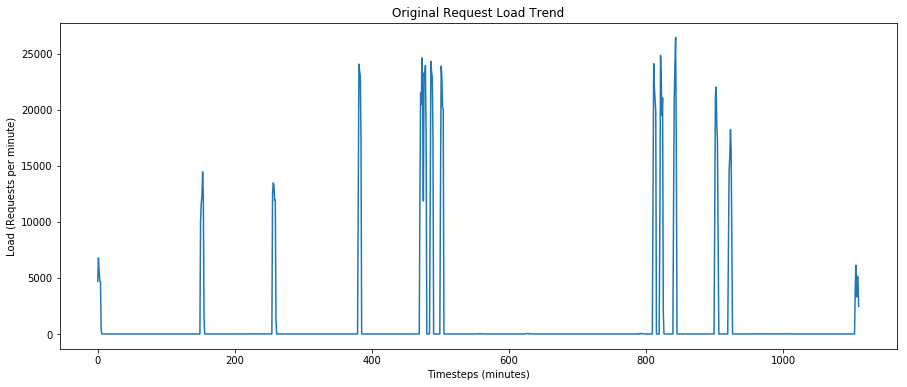

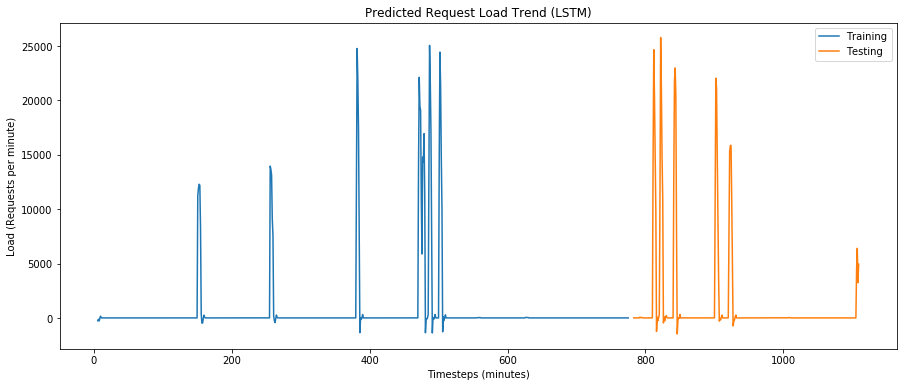

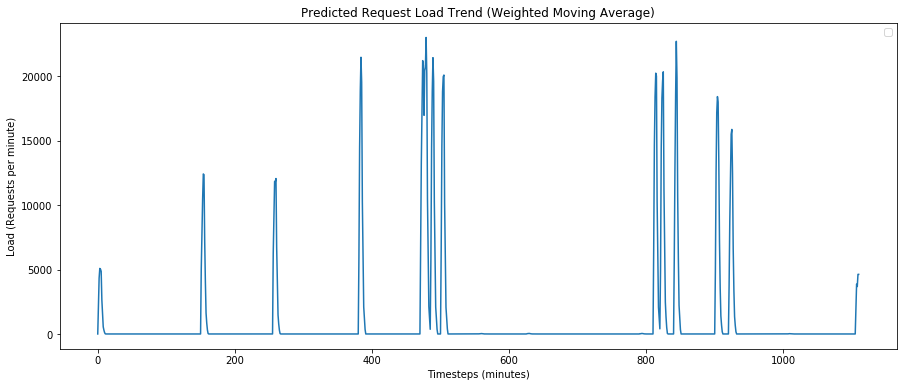

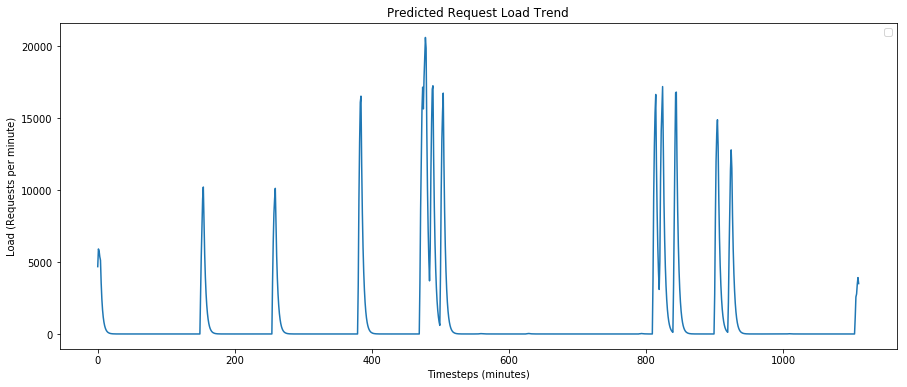

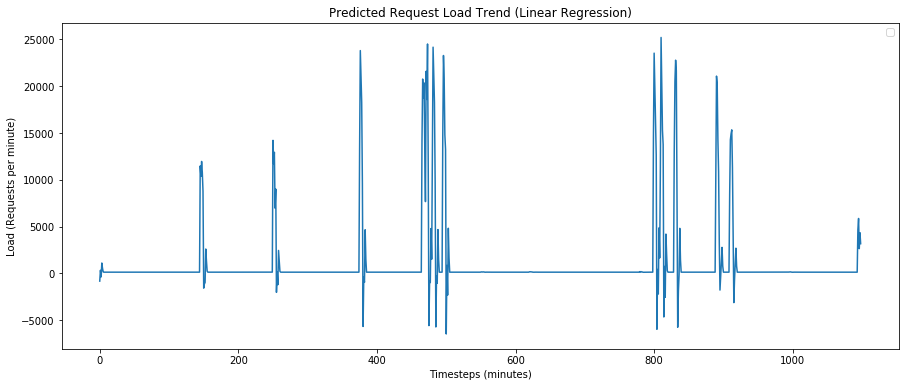

In [1190]:
plot_original(df_features_lstm_pd.values)
plot_predictions_lstm(df_features_lstm_pd.values, train_predict_lstm, test_predict_lstm)
plot_wma_pred()
plot_ema_pred()
plot_linear_reg_pred()

From the above visualization, it looks like LSTM predictions follows the original trend the most closely, although there are small spikes of negative predictions. The weighted average and exponential averages also does reasoanbly well, but they are a little coarse at places. The linear regression results seem to be the worst here with big negative spikes.

Comparing R2 score and MAE:

- Weighted Moving Average

  R2 Score: 0.51 MAE
  
  MAE: 797.07 MAE


- Exponential Moving Average

  R2 Score: 0.68 MAE
  
  MAE: 759.18 MAE


- Linear Regression

  R2 Score: 0.791538
  
  MAE: 869.26


- LSTM

  R2 Score: 0.82
  
  MAE: 660.36

### More things that could have been tried

- Instead of a simple linear regression, we could try polynomial regression
- Other models like Random Forest, Boosted trees etc

### Predict session length for a Given IP

This is one of the problems I gave a good amount of thought as to how to approach it. Personally, I think the question is a little vague - we can formulate the problem in different ways:

- A very naive way of interpreting this problem is just to take the average session lengths per user/IP based on our previously sessionized data and consider the averages as prediction. 

- Given that the session length for a user/IP might actually depend on factors like what hour of the day he is having the session in. For example, a particular user might have a pattern of spending more times in a session during the evening time, but less times suring other times of the day. Taking this into consideration, we can try to predict the session length for an IP given a particular hour of the day, rather than just predicting for an IP. We can try a linear regression type approach for doing this.

- Another approach can be a time-series based approach. However, unlike the previous case (predicting next minute load), this will be trickier since user sessions don't take place continuously one after another, and also again, session length could be a function of specific hours of the day (and also on specific day of the week, whether it is a holiday or not) etc. So we could formulate the problem like for predicting the next session length given some history, however, unlike the next minute load prediction case, we need to consider some periodic history here. For example:
    - Let'say we find that a user has some periodic daily session behaviour like the following:
            10 AM     1 PM      5 PM      10 PM
            -------------------------------------------
            20 min    5 min     40 min    2 hours (these are approximation)
      
      And let's say we also determine that the user has a maximum of 4 sessions per day.
      Now using this sort of pattern , we can first try to formulate an LSTM type problem, where the prediction will       be done for 4 steps ahead in the future, instead of the very next step.
      
  For approching the problem in this way though, I don't think we have enough data in the given context, since we have only portion of one day's data.
  
Below I will first do approach 1 (naive average approach per IP) and then try approach 2 (regression) mentioned above. However, since we only have one day's data, I will only train the model and do the prediction on the trainin data, since a proper train-test split is not possible for one day's data. And even for that, there isn't really enough data here.

### Linear Regression approach (hour based)

In [82]:
hours = [i for i in range(0, 24)]
hours_df = spark.createDataFrame(hours, IntegerType())
hours_df.createOrReplaceTempView('hours_df')

hour_encoder = OneHotEncoderEstimator(inputCols=['value'],
                                 outputCols=['hour_vec'])
hour_model = hour_encoder.fit(hours_df)
hour_encoded = hour_model.transform(hours_df)
hour_encoded.createOrReplaceTempView('hour_encoded')

df_session_with_length_and_hour = \
        df_session_with_length.select('client_ip',
                                      F.hour(F.col('session_start_time').cast(TimestampType())).alias('hour'),
                                     'session_length')

df_session_with_length_and_hour.createOrReplaceTempView('df_session_with_length_and_hour')

In [83]:
def get_client_df(ip):
    df_client_hour = spark.sql("""
        select h.value as hour,
               x.client_ip as client_ip
        from hours_df h
        cross join (select '{ip}' as client_ip) x
    """.format(ip=ip))
    df_client_hour.createOrReplaceTempView('df_client_hour')


    df_features_session = spark.sql("""
        select h.client_ip,
                h.hour as hour,  
                avg(coalesce(sr.session_length, 0)) as session_length
        from df_client_hour h
            inner join df_session_with_length_and_hour sr
            on sr.hour = h.hour
            and sr.client_ip = h.client_ip
        group by 1, 2
        order by 1, 2
    """)

    df_features_session.createOrReplaceTempView('df_features_session')

    df_features_session = spark.sql("""
        select  d.client_ip,
                h.hour_vec,  
                d.session_length
        from df_features_session d
            inner join hour_encoded h
            on h.value = d.hour
    """)
    df_features_session.createOrReplaceTempView('df_features_session')
    
    return df_features_session

def predict_session_length_for_ip(ip):
    df_client = get_client_df(ip)
    vdf_features_sess = get_df_for_regression(df_client, ['hour_vec'], 'session_length')    
    lr_sess_model = perform_linear_regression(vdf_features_sess, 'session_length')
    return vdf_features_sess, lr_sess_model

In [84]:
vdf_features_sess, lr_sess_model = predict_session_length_for_ip('220.226.206.7')

Coefficients: [0.0,0.0,-108.4330048366117,0.0,0.0,-107.68827801534408,-52.05058711034297,0.0,0.0,-53.97620606431383,1752.8587265600186,0.0,0.0,0.0,0.0,2951.1533909276377,0.0,1207.8127694730201,0.0,7.599785195277663,0.0,-70.56098034257863,0.0]
Intercept: 296.2858089066227


#### Let's evaluate the R2 score and MAE on the same data it was trained on. Again, this doesn't necessarily indicate anything useful since we are evaluating on the same training data.

In [85]:
lr_predictions_sess = lr_sess_model.transform(vdf_features_sess)
# lr_predictions.select("prediction", "request_count", "features").show(5, False)
lr_evaluator_sess = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="session_length",metricName="r2")
print("R Squared (R2) = %g" % lr_evaluator_sess.evaluate(lr_predictions_sess))

R Squared (R2) = 0.999999


In [86]:
y_actual_sess = vdf_features_sess.select('session_length').toPandas()
y_predictions_sess = lr_predictions_sess.select('prediction').toPandas()

In [87]:
score = mean_absolute_error(y_actual_sess, y_predictions_sess)
print('Score: %.2f MAE' % (score))

Score: 0.73 MAE


### Predict the number of unique URL visits by a given IP

Since we are looking for unique URL visits per IP for the lifetime, I was a little confused about how that can be predicted based on just one single day's log file. Ideally, I would say that's not possible. The best I can think of is something like this:

- Assume that the average number of days of a IP/user lifetime is x days.
- Get the total number of unique URLs per day for the IP. Call this n.
- Assuming every day, y% of new unique URL hits are encountered - on top of what has already been hit in the previous days, we can come up with a heuristic like:

   n + (n * y) + (n * y^2) + ... + (n * y^(x-1))
   
- Now the challenge is how we figure out x and y. I don't have anything off top as to how to approximate x.
  For y, again as a heuristic, we could try to leverage the session information we have for a single day. For   
  example, if a user has 3 sessions during the day:
    - session 1 - 5 unique urls
    - session 2 - 6 unique urls, but only 2 of them new, so retain ratio = (6 - 2) /5 = 0.8
    - session 3 - 6 unique urls, but only 1 of them new, so retain ratio = (6 - 1) /7 = 0.714
    So approximate value of y will be:
    
    1 - (0.8 + 0.714) / 2 = 1 - 0.757 = 0.353
  
  Now this value of y can be plugged into the formula above to get an approximation of the number of unique URL visiits by a given IP.
  
  Because of time limitations, I haven't tried to implement the y approximation here. Below I only calculate the number of unique URLs for the day per IP.

In [88]:
df_url_count = spark.sql("""
    select client_ip, count(distinct url) as url_count
    from df_with_time_and_ip
    group by client_ip
""")


In [89]:
df_url_count.show(5, False)

+--------------+---------+
|client_ip     |url_count|
+--------------+---------+
|27.63.186.72  |6        |
|14.139.82.134 |108      |
|117.241.152.20|34       |
|113.193.114.25|84       |
|120.61.47.36  |7        |
+--------------+---------+
only showing top 5 rows



Now, let's say if we somehow know that the average lifetime of an IP is 5 days, and we somehow figured that the retain ratio y is say 0.8. We can calculate the approximate unique URLs visit by IP 14.139.82.134 as:

In [91]:
108 + (108 * 0.2) + (108 * math.pow(0.2, 2)) + (108 * math.pow(0.2, 3)) + (108 * math.pow(0.2, 4))

134.9568

Once again, I would admit that this whole scheme is a wild heuristic imagination I came up with and I demand no justification to it. Would be happy to discuss.

## References:

[1] Finding user sessions with SQL. https://mode.com/blog/finding-user-sessions-sql

[2] Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/